<a href="https://colab.research.google.com/github/good0neighbour/ESTCampAI/blob/main/%EC%96%B8%EC%96%B4%EC%A7%80%EB%8A%A5(%ED%97%88%EA%B9%85%ED%8E%98%EC%9D%B4%EC%8A%A4_NLP)/ex02_BERTopic_%EA%B8%B0%EB%B0%98_%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%A7%88%EC%9D%B4%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/ESTCampAI/언어지능(허깅페이스_NLP)

/content/drive/MyDrive/ESTCampAI/언어지능(허깅페이스_NLP)


In [2]:
# transformers[torch] 설치
!pip -q install transformers[torch]

In [3]:
!pip show transformers

Name: transformers
Version: 4.57.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


## 목표
- 사전학습 되어있는 모델만 활용하여 [요약] -> [임베딩] -> [클러스터링(비지도)] -> [감성분석]을 포함하는 통합 분석 파이프라인 구현

## 시나리오

### 배경
- “K-인사이트”는 <u>월간 **50만 건** 이상의 SNS 대화를 처리하는 기업용 분석 플랫폼</u>  
- AI Hub의 한국어 SNS 데이터(“미용과건강”, “식음료”, “일과직업”) 기반으로 사용자의 대화 내용을 <u>자동 탐지·분류</u>해야 함  
- 긴 대화 로그에는 <u>메타정보·반복 발화·잡음</u>이 포함되어 있어, <u>핵심 주제 파악</u>과 <u>감성 분석</u>이 어려움  
- <u>요약 → 임베딩 → 클러스터링(군집화) → 감성분석</u>의 통합 파이프라인으로 <u>자동 인사이트 생성</u>이 필요  

```python
# 주요 이해관계자
- 데이터 사이언스팀 : 통합 분석 파이프라인 개발·유지보수  
- 제품 기획팀       : 사용자 인사이트 기반 서비스 기획  
- 운영팀           : 실시간 토픽·감성 모니터링 시스템 운영  
- 마케팅팀         : 토픽별 감성 결과로 캠페인 전략 수립  
```

> AI Hub - 한국어 SNS 데이터셋 링크
> - https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=114
> - JSON 형식으로 제공되며, 각 대화에 메타정보와 발화(utterance) 리스트(body)가 포함
> - 실습상 데이터셋이 방대하여, 실습상 `미용과건강`, `식음료`, `일과직업` 만 활용
>    - 기존 라벨 : 개인관계, 미용과건강, 상거래(쇼핑), 시사교육, 식음료, 여가생활, 일과직업, 주거와 생활, 행사

In [4]:
# 압축 파일 해제
# !unzip -q ./data/Korean\ SNS.zip -d ./data/Korean_SNS

## 1. 데이터준비

In [5]:
import os, json, re
# os: 운영체제 기능을 활용할 수 있는 라이브러리
# - 입출력 제어
# - 파일 제어 기능

# json: 데이터 폴더 내부에 json 파일 존재, 해당 확장자 형태의 파일을 다루기

# re: 정규표현식, 문자열 처리 해주는 기능

In [6]:
# 경로 설정
train_dir = './data/Korean_SNS/Training/'
val_dir = './data/Korean_SNS/Validation/'

# 라벨값 크기 제어
# 원본 라벨 크기: train - 353979 개, val - 44249개
# - 실습하기에는 너무 방대한 양이라 제한해서 진행해보자
limit_label = 200

- json 데이테 로드, 샘플 하나 불러와서 간단하게 확인해보기

In [7]:
# 샘플로 사용할 파일 한 개 선택하기
sample_fname = os.listdir(train_dir)[0]
sample_path = os.path.join(train_dir, sample_fname)
sample_path

'./data/Korean_SNS/Training/미용과건강.json'

In [8]:
# json 파일 내부를 확인해보자
with open(sample_path, 'r', encoding = 'utf-8') as f:
  dataset = json.load(f)

dataset.keys()

dict_keys(['numberOfItems', 'data'])

In [9]:
# data 접근해보기
sample = dataset['data'][0]
sample

{'header': {'dialogueInfo': {'dialogueID': '403d6d5f-6241-505b-87a0-fb755d666cf6',
   'numberOfParticipants': 2,
   'numberOfUtterances': 18,
   'numberOfTurns': 6,
   'type': '일상 대화',
   'topic': '미용과 건강'},
  'participantsInfo': [{'participantID': 'P01',
    'gender': '여성',
    'age': '20대',
    'residentialProvince': '인천광역시'},
   {'participantID': 'P02',
    'gender': '여성',
    'age': '20대',
    'residentialProvince': '경기도'}]},
 'body': [{'utteranceID': 'U1',
   'turnID': 'T1',
   'participantID': 'P01',
   'date': '2017-08-13',
   'time': '15:03:00',
   'utterance': '마니아프세여???'},
  {'utteranceID': 'U2',
   'turnID': 'T1',
   'participantID': 'P01',
   'date': '2017-08-13',
   'time': '15:04:00',
   'utterance': '#@시스템#사진#'},
  {'utteranceID': 'U3',
   'turnID': 'T1',
   'participantID': 'P01',
   'date': '2017-08-13',
   'time': '15:04:00',
   'utterance': '흙흙흙'},
  {'utteranceID': 'U4',
   'turnID': 'T2',
   'participantID': 'P02',
   'date': '2017-08-13',
   'time': '15:04:00',
  

In [10]:
# body 내부의 실제 대화 문장, 단어에 접근해보기
sample['body'][0]['utterance']

'마니아프세여???'

In [11]:
# 대화의 모든 발화(utterance)를 공백으로 연결하여 하나의 텍스트를 생성해보자
sample_text = " ".join(turn['utterance'] for turn in sample['body'])
sample_text

'마니아프세여??? #@시스템#사진# 흙흙흙 아 개피곤 ㅋㅋ 님 괜찮아여? 왜 먹고 먹고 머고만 햇는데 몸이 무겁지 걸은것도 별로 없는데 몰라여 응가싸서 그런가 고되다 똥싸서 몸무게 빠졋나 아삐건해 미틴ㅋㅋㅋㅋㅋㅋ 진짜 7-800그람 빠짐 나 몸이 너무 무거워서 몸무게 쟀는데 빠져서 놀랏어 너무 무서워'

In [13]:
# 각각의 모든 대화를 하나의 문장으로 만들어보기
# json - 3개
# 각각의 대화
# 대화 내부 발화 여러개 존재

from tqdm.auto import tqdm
# 함수가 실행되는 상태를 로딩바처럼 출력해주는 기능

def load_and_normalize(dir_path):
  """
  지정한 디렉토리(dir_path) 내 모든 JSON 파일을 순회하며,
  각 대화(dialog)의 'body' 필드에 담긴 발화(utterance)를 하나의 문서(text)로 연결한 뒤
  리스트로 반환하는 함수

  인자(dir_path) : JSON 파일들이 들어 있는 폴더 경로
  반환(corpus) : 대화별로 병합된 텍스트 리스트
  """

  corpus = [] # 결과를 담을 빈 리스트

  # 해당 폴더 내 모든 이름을 가져와서 반복
  for fname in tqdm(os.listdir(dir_path), desc = f"Loading {dir_path}"):
    file_path = os.path.join(dir_path, fname) # 각 파일의 전체 경로 생성 부분
    count = 0                                                 # 라벨당 문서 수 카운터 초기화

    # json 파일 로드
    with open(file_path, "r", encoding = 'utf-8') as f:
      dataset = json.load(f) # 외부 파일 확장자가 json, json 구조 파악

    # dataset -> 대화 내용 (dialog)
    for dialog in tqdm(dataset['data'], desc = f"proprecessing {fname}"):
      # 라벨당 제한 횟수(개수) 초과 시 반복 종료
      if count >= limit_label:
        break

      # 각 대화(dialog)에서 발화부분 접근 -> 하나의 문장 셋팅
      text = " ".join(turn['utterance'] for turn in dialog['body'])

      # 결과적으로 하나의 문장으로 바뀐 대화를 저장해줘야하는 상황
      corpus.append(text) # 빈 리스트에 문장을 추가
      count += 1               # 문서 카운터 1씩 증가, count = count + 1
    return corpus

In [14]:
# train, val 경로 - 적용
train_corpus = load_and_normalize(train_dir)
val_corpus = load_and_normalize(val_dir)

Loading ./data/Korean_SNS/Training/:   0%|          | 0/3 [00:00<?, ?it/s]

proprecessing 미용과건강.json:   0%|          | 0/99383 [00:00<?, ?it/s]

Loading ./data/Korean_SNS/Validation/:   0%|          | 0/3 [00:00<?, ?it/s]

proprecessing 식음료.json:   0%|          | 0/18328 [00:00<?, ?it/s]

In [17]:
# 불러온 데이터 수 및 샘플 출력
print(f">>> train 문서의 수: {len(train_corpus)}")
print(f">>> val 문서의 수: {len(val_corpus)}")
print(f">>> 샘플 문서 3개 확인: ")
for i in range(3):
  # 앞의 100자씩만 출력하면서 3개의 문서를 확인해보자
  print(f"[train 문서 {i+1}] {train_corpus[i][:40]}...")
  print(f"[val 문서 {i+1}] {val_corpus[i][:40]}...\n")

# 문장의 길이가 길다면, 주요 의미를 내포한 단어를 쉽게 확인하기 어려움
# 긴 문장에 대해서 요약 처리 추가 해주면 어떨까?

>>> train 문서의 수: 200
>>> val 문서의 수: 200
>>> 샘플 문서 3개 확인: 
[train 문서 1] 마니아프세여??? #@시스템#사진# 흙흙흙 아 개피곤 ㅋㅋ 님 괜찮아여?...
[val 문서 1] 애네 꼬치도 하네 맛나겟다 우리도 예전엔 햇는데 지금은 딱 차례상에 올리...

[train 문서 2] 구냥 기른거같은데... ㅋ켘캨ㅋㅋㅋ ㅋㅋㅋㅋㅋㅋ알지 뭔날린디 #@이름# ...
[val 문서 2] 자기 먹고찌푼걸루 ㅎㅎㅎㄹ 열라면사서 먹어여겟군! 소시지도 팡팡 넣구 응...

[train 문서 3] 다자기랑먹느라찐디 아닌데요!! 평일에 9시에 저녁을먹눈데 당연히찌죠 아닌...
[val 문서 3] 옥수수 먹고싶다 아까자기전에 기영이처럼 옥수수 상상함 ㅋㅋㅋㅋㅋ 옥수수....



## 2. 대화요약
- 문서 길이 절감: 요약을 통해 핵심 내용만 남기면 후속 임베딩, 토픽 모델링 연산 속도를 높일 수 있음
- 노이즈 제거: 불필요한 대화(인사, 중복 발화 등)를 압축하여 중요한 주제어 비중을 높임
- 토픽 명확화: 긴 대화 대신 요약문을 사용하면 BerTopic이 더 뚜렷한 주제어를 학습할 수 있음 -> 확실한 카테고리로 문장을 구분해나갈 수 있음

In [18]:
import torch # 토치 형태의 텐서를 사용함
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# AutoTokenizer: 다양한 사전학습 토크나이저를 쉽게 로드 기능
# AutoModelForSeq2SeqLM : Seq2Seq(입력 -> 출력) 구조의 언어모델 로드하는 기능 ( 요약, 번역 등 과제 해결하는 모델)

### T5
- T5 = Text-to-Text Transfer Transformer  
입력(input)과 출력(output)을 모두 텍스트 형태로 다루는 모델입니다.
번역, 요약, 질의응답, 분류, 문장 생성 등 모든 작업을 하나의 통합 프레임워크로 처리할 수 있어요.

- 구조적으로는 “Encoder-Decoder Transformer”  
T5는 Transformer 구조를 그대로 사용하지만,   
BERT처럼 인코더(encoder) 부분은 입력 문장 이해 담당
GPT처럼 디코더(decoder) 부분은 출력 문장 생성 담당  
즉, BERT + GPT의 장점을 결합한 형태입니다.  

- 요약 모델(KoT5) 허깅페이스 : https://huggingface.co/psyche/KoT5-summarization
- KoT5: 한국어 T5(Text-to-Text Transfer Transformer) 모델  
  
> #### 사전학습 정보 (Pre-training)
- **코퍼스**  
  - 위키백과, 신문기사 등 23개 출처에서 수집한 총 939 GB 원시 데이터 → 전처리 후 약 42 GB 말뭉치 사용
- **체크포인트**  
  - KoT5-Small: 6 layers, hidden_size=512, 60M 파라미터  
  - KoT5-Base: 12 layers, hidden_size=768, 220M 파라미터

> #### 파인튜닝(Fine-tuning)
- **데이터셋**  
  - AI-Hub “SNS 요약” 데이터셋  
- **디코딩 설정**  
  - greedy decoding  
  - 최대 길이 `max_length=256`, `repetition_penalty=2.0` 적용
  - repetition_penalty : 같은 토큰이 반복적으로 나오면 penalty를 적용해서 해당 토큰의 logit을 낮춰줌 (값은 1.0 이상이며, 값이 클 수록 penalty를 세게 적용)

- T5 아키텍처
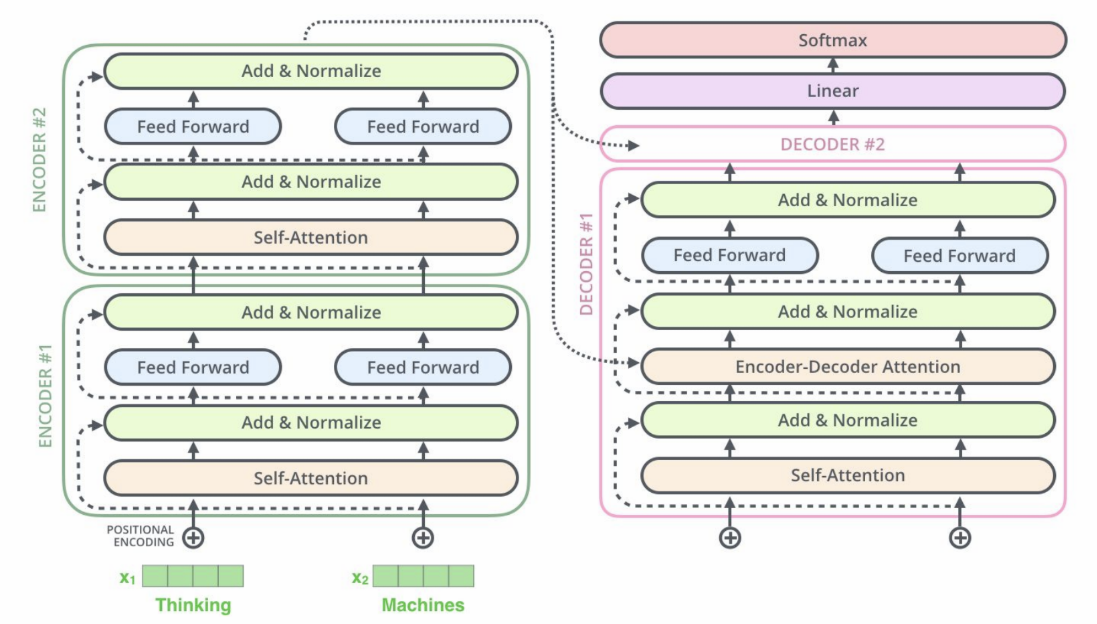

In [19]:
# 사전학습 요약 모델 명
model_name = 'psyche/KoT5-summarization'

In [20]:
# 요약 모델 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [23]:
# 지정된 디바이스 확인 ( gpu 연결 확인 )
# cuda : gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print('사용하는 device:', device)

사용하는 device: cpu


In [25]:
# 요약 모델 연결 - cuda(gpu)로 모델을 명확하게 설정
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
model
# .to(device): 지정된 디바이스(일반적으로 gpu)로 텐서 이동

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

- 샘플 텍스트로 용약하는 모델 사용해보기

In [26]:
# 샘플 텍스트 준비
sample_text = train_corpus[0]
sample_text

'마니아프세여??? #@시스템#사진# 흙흙흙 아 개피곤 ㅋㅋ 님 괜찮아여? 왜 먹고 먹고 머고만 햇는데 몸이 무겁지 걸은것도 별로 없는데 몰라여 응가싸서 그런가 고되다 똥싸서 몸무게 빠졋나 아삐건해 미틴ㅋㅋㅋㅋㅋㅋ 진짜 7-800그람 빠짐 나 몸이 너무 무거워서 몸무게 쟀는데 빠져서 놀랏어 너무 무서워'

In [27]:
# 입력 텍스트 토큰화 및 gpu로 이동
inputs = tokenizer(
    sample_text,          # 토큰화 대상 문자열
    truncation = True,    # 길이 초과 시 잘라내기
    max_length = 512,     # 최대 토큰 길이 512 허용
    return_tensors = 'pt' # 데이터 처리 난 후 텐서의 형태
).to(device)              # 토큰화된 데이터가 gpu 메모리로 할당

# input_ids: 토큰화 되고 난 후의 단어에 매칭된 ID 숫자값
# attention_mask: 1로 작성된 것은 실제로 문장 내에서 토큰화된 데이터라는 설명
#                 0로 작성된 것은 문장 내에 포함되지 않은 데이터라는 의미

In [28]:
# 요약 시퀀스 생성
# 모델 -> 요약 명령 시키기(생성)
outputs = model.generate(
    **inputs,
    max_length = 100,      # 요약문의 최대 토큰 길이 설정
    min_length = 20,       # 요약문의 최소 토큰 길이 설정
    num_beams = 4,         # 빔 서치 수: 매 단계마다 가장 가능성 높은 4개 후보 토큰을 유지하며 탐색을 하는 부분
    early_stopping = True, # 조기 학습 중단: 중단 여부를 확인시킬 수 있도록 조기학습 중단을 연결
                           # EOS(문장 끝)을 마나면 더이상 문장을 생성하지 않도록 하게 하는 설정 (즉시 생성 중단)
                           # 불필요한 패딩, 중복 방지
    length_penalty = 2.0  # 길이 패널티 : 생성 길이에 가중치를 주어 스코어를 조정하는 설정
                          # 값 > 1.0 : 긴 시퀀스일수록 패널티 값이 짧은 출력을 선호하도록 함
                          # 값 < 1.0 : 긴 시퀀스에 대한 패널티 값이 작아져 긴 출력을 유도하도록 함
)

In [29]:
# 요약 (인코딩) -> 문자로 다시 변경(디코딩)
summary = tokenizer.decode(
    outputs[0],                # 생성된 토큰 ID목록 연결 (1개 문장 인덱스에 접근)
    skip_special_tokens = True # <pad>, <eos> 등 패딩 부분, 끝값에 대한 인식을 위한 특수 토큰을 제거하라는 의미
)

summary

'왜 먹고 먹고만 햇는데 몸이 무겁지 걸은것도 별로 없는데 몰라여 응가싸서 그런가 고되다 똥싸서 몸무게 빠졋나 아삐건해 미틴 진짜 7-800그람 빠짐 나 몸이 너무 무거워서 몸무게 쟀는데 빠져서 놀란다'

In [30]:
# 텍스트 요약 함수 정의해보자
def summarize(text):
  """
  입력 텍스트를 KoT5모델로 요약하는 기능(함수)
  """

  # 1) 입력 토큰화 및 gpu 이동
  inputs = tokenizer(
      text,          # 토큰화 대상 문자열
      truncation = True,    # 길이 초과 시 잘라내기
      max_length = 512,     # 최대 토큰 길이 512 허용
      return_tensors = 'pt' # 데이터 처리 난 후 텐서의 형태
  ).to(device)

  # 2) 요약문 생성(모델) - generate
  outputs = model.generate(
      **inputs,
      max_length = 100,      # 요약문의 최대 토큰 길이 설정
      min_length = 20,       # 요약문의 최소 토큰 길이 설정
      num_beams = 4,         # 빔 서치 수: 매 단계마다 가장 가능성 높은 4개 후보 토큰을 유지하며 탐색을 하는 부분
      early_stopping = True, # 조기 학습 중단: 중단 여부를 확인시킬 수 있도록 조기학습 중단을 연결
                            # EOS(문장 끝)을 마나면 더이상 문장을 생성하지 않도록 하게 하는 설정 (즉시 생성 중단)
                            # 불필요한 패딩, 중복 방지
      length_penalty = 2.0  # 길이 패널티 : 생성 길이에 가중치를 주어 스코어를 조정하는 설정
                            # 값 > 1.0 : 긴 시퀀스일수록 패널티 값이 짧은 출력을 선호하도록 함
                            # 값 < 1.0 : 긴 시퀀스에 대한 패널티 값이 작아져 긴 출력을 유도하도록 함
  )

  # 3) 디코드 과정의 코드
  summary = tokenizer.decode(outputs[0], skip_special_tokens = True)
  return summary

In [31]:
# train 샘플 요약
summaries = [summarize(doc) for doc in tqdm(train_corpus, desc = 'Summarizing...')]
summaries

Summarizing...:   0%|          | 0/200 [00:00<?, ?it/s]

['왜 먹고 먹고만 햇는데 몸이 무겁지 걸은것도 별로 없는데 몰라여 응가싸서 그런가 고되다 똥싸서 몸무게 빠졋나 아삐건해 미틴 진짜 7-800그람 빠짐 나 몸이 너무 무거워서 몸무게 쟀는데 빠져서 놀란다',
 '알고 뭔날린디 #@이름# 털을 보면 관리를 해서 스탈이구나 싶은데 #@이름#는 그냥인지 스타일인지 헷갈림 그냥인느낌이엇어 엌 마구 기르는느낌 그칰',
 '평일에 9시에 저녁을 먹는데 당연히찌가 아닌데요? 데이트할때마다 배터지게 먹어서 그런건데여?',
 '무게가 안 줄어서 몸무게가 안 줄어서? 무게는 중요한게 아니야 나 몸무게 체크 안 해 허허허',
 '가을이 되면 단발을 하고 싶은데 후회 천퍼 할 구 알아서 그냥 있는다....... 나도 근데 가을되면 단발 하고 싶은데 과연 후회 천퍼 할 구 알아서 그냥 있는다.......',
 '어제 몸이 안좋아서 낮에 내리 자고 한밤에 일어나서 새벽에 잤어 수술 빨리 해야긋다 무섭다  그래도 안해도 되는디 얼릉해 온몸이 너무 가렵길래 어제 가려움증 약을 사와서 먹으니 낫네',
 '오빠 정처기 시험이 4월 27일인데 웅 토익이 4월 28일 시험이네 도랏나..',
 '식단관리하면서 너무 부작용이 많아 식단관리  소요없어 그냥 이거 그래도 안하는 것보단 나은거 아냐?',
 '  12분걸리는 넬기가 3분만에 잡는다구! 어제보단 많이 나아짐 이양 다행쓰 예?',
 '오빠도 코로나 검사한거 오빠 양성이면 어머니도 백퍼일텐데 옹옹 했지  걱정이다 나도 걱정은 되는데 안걸렷을꺼얌 재채기는 에어컨키고 살아서 감기얌 증상이야 그렇다치고 아닐꺼야 무증상도 있어서  근데 코로나 걸리면 휴유증이 심해서 그게 걱정이야 휴유증도 있대?',
 '그런데 이게 나오면 대부분 1차 단계여서 고위험군 아니먼 약물하면 된뎅 쩝스바리 면역력관리 잘해야 하는뎅 그래도 좀 그렇잔아 찜찜라지 걱정이군',
 '손가락이 부러질정돈 아닌데 너무 가늘어서  그정돈아님 손이 길어서그렇지 얇진않아 길어서 얇아보이는건가 ',
 '사랑니가 아프긴한데 통각이 없잖아 통각이 없